In [1]:
# import required modules
%cd /home/gridsan/lchan/git-remotes/polychrom_analysis
import os
import sys
from pathlib import Path
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
import matplotlib.colors as colors
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable

import polychrom
from polychrom.hdf5_format import list_URIs, load_URI, load_hdf5_file

from post_processing.visualization import *
from post_processing.analysis import *
from post_processing.compscores import *
from post_processing.msd import *

import random
import csv
import math
from scipy.stats import rv_continuous

import nglutils as ngu
import nglview as nv

/home/gridsan/lchan/git-remotes/polychrom_analysis


In [2]:
# for visualization of polymer
%load_ext autoreload
%autoreload 2

In [2]:
# load chromosomal data
ABids = np.loadtxt("data/ABidentities_chr21_Su2020_2perlocus.csv", dtype=str) # make sure to change this!
ids = (ABids == "A").astype(int)

# parameter sweep values
param_set = []
act_ratio = [1, 2, 3, 4, 5]
e0 = [0, 0.075, 0.15, 0.225, 0.3]
for a in act_ratio:
    for e in e0:
        param_set.append((a, e))

# contour parameter values (normal)
param_set = []
param_set.extend([(1, 0.175), (2, 0.12), (4, 0.04)]) # normal log clustered
#param_set.extend([(1, 0.25), (2, 0.17), (3, 0.1), (4, 0.04)]) # artificial1
#param_set.extend([(1, 0.25), (2, 0.16), (3, 0.1), (4, 0.05)]) # artificial2
#param_set.extend([(1, 0.25), (2, 0.17), (3, 0.11), (4, 0.06)]) # blocky1
#param_set.extend([(1, 0.23), (2, 0.15), (3, 0.10), (4, 0.05)]) # blocky1

simnames = [f'stickyBB_{BBenergy}_act{act_ratio}' for (act_ratio, BBenergy) in param_set]

In [3]:
# functions for radial distribution calculation and plotting
# take 100 snapshots/conformations starting from mid-time (so 2*10^7 timesteps), each 20 copies --> 2000 conformations total
# if time-clustered, take 2200 conformations (200 chains from 11-timestep window)
'''Ongoing notes:
1. g(R) should be a function centered around 1.0 since measure is non-dimensional enrichment ratio?
'''
def radial_distribution(ids, conf_path, start=10000, end=20000):
    conf = list_URIs(conf_path)
    conformations = conf[start:end]
    num_A = len(ids[ids==1]) # for normalization later
    num_B = len(ids[ids==0])
    num_confs = 0
    rsquared_A = []
    rsquared_B = []
    N = len(ids)
    for conformation in conformations:
        pos = load_URI(conformation)["pos"]
        ncopies = pos.shape[0] // N
        for i in range(ncopies):
            posN = pos[N * i : N * (i + 1)]
            posN_A = posN[ids==1]
            posN_B = posN[ids==0]
            center_mass = np.mean(posN, axis=0)
            posN_A2 = [sum((posN_A[i] - center_mass)**2) for i in range(len(posN_A))] # using COM instead of absolute center; alternatively use globule center
            posN_B2 = [sum((posN_B[i] - center_mass)**2) for i in range(len(posN_B))]
            rsquared_A.extend(posN_A2)
            rsquared_B.extend(posN_B2)
        num_confs += ncopies
    rsquared_A = [math.sqrt(rsq) for rsq in rsquared_A] # convert to r, not r^2
    rsquared_B = [math.sqrt(rsq) for rsq in rsquared_B]
    return rsquared_A, rsquared_B
    #df2 = pd.DataFrame(rsquared)
    #df2.to_csv(Path(savepath) / f"rsquared_{simstring}.csv", index=False)
    
def plot_radial_dist(rsquared_A, rsquared_B, stickiness, act, ax=None, start=10000, end=20000, blocks=False):
    if ax is None:
        fig, ax = plt.subplots()
    num_bins = 100 # change back to 100
    binwidth = (max(rsquared_A + rsquared_B) - min(rsquared_A + rsquared_B))/num_bins
    bins = np.arange(min(rsquared_A + rsquared_B), max(rsquared_A + rsquared_B)+binwidth, binwidth)
    
    r_chain = (((num_A+num_B) * (0.5) ** 3) / 0.2) ** (1 / 3) # approximately 9
    width = 10.0
    r = r_chain + width 
    phi_A = num_A*2200/(4/3*math.pi*r**3) # where 2200 is number of conformations (200 copies * 11 snapshots)
    phi_B = num_B*2200/(4/3*math.pi*r**3)
    
    n_a, bins_a = np.histogram(rsquared_A, bins=bins)
    n_b, bins_b = np.histogram(rsquared_B, bins=bins)
    new_a = []
    new_b = []
    for j in range(len(n_a)):
        shell_volume = 4*math.pi*((bins_a[j+1] + bins_a[j])/2)**2 # take R as the middle of a bin. bins_a and bins_b should be same
        new_a.append(n_a[j]/(phi_A*shell_volume*binwidth))
        new_b.append(n_b[j]/(phi_B*shell_volume*binwidth))
        
    ax.hist(bins_a[:-1], bins=bins_a, weights=new_a, color='r', label='A', alpha=0.5)
    ax.hist(bins_b[:-1], bins=bins_b, weights=new_b, color='b', label='B', alpha=0.5)

    ax.set_xlabel('Distance from COM, R')
    ax.set_ylabel('g(R)')
    ax.legend()
    if (blocks):
        ax.set_title(f'blocks{start}-{end}')
    else:
        ax.set_title(f'$E_BB$ = {stickiness}, $A_A / A_B$ = {act}')
    
def plot_radial_panel(simpaths):
    num_rows = 5
    num_cols = 5
    fig = plt.figure(figsize=(3*num_cols, 2 + 2*num_rows))
    #extract activity / stickiness from simpath name
    BBenergy = np.array([float(simname.split('_')[1]) for simname in simpaths])
    activities = np.array([float(simname.split('act')[1]) for simname in simpaths])
    fig.suptitle('Radial distribution', fontsize=14, fontweight='bold')
    gs = GridSpec(nrows=num_rows, ncols=num_cols, width_ratios=[100]*num_cols)
    for i in range(len(simpaths)):
        x = i // num_cols
        y = i % num_cols
        ax = fig.add_subplot(gs[x, y])
        conf_path = f"/home/gridsan/lchan/git-remotes/polychrom_analysis/artificial_chr/{chromo}/{simpaths[i]}/runs20000_2000_20copies"
        rsq_A, rsq_B = radial_distribution(ids, conf_path)
        plot_radial_dist(rsq_A, rsq_B, BBenergy[i], activities[i], ax=ax)

        if np.all(activities == activities[0]):
            ax.set_title(r'$E_{BB}=$' + f'${BBenergy[i]}kT$', fontsize=12)
        elif np.all(BBenergy == BBenergy[0]):
            ax.set_title(f'$A_A/A_B={activities[i]}$', fontsize=12)
        else:
            ax.set_title(r'$E_{BB}=$' + f'${BBenergy[i]}kT$' + f' $A_A/A_B={activities[i]}$', fontsize=12)
            
    fig.tight_layout()
    plt.show()

def plot_radial_dynamics_panel(simpaths, blocks=False):
    num_rows = 10
    num_cols = 10
    fig = plt.figure(figsize=(3*num_cols, 2 + 2*num_rows))
    #extract activity / stickiness from simpath name
    BBenergy = np.array([float(simname.split('_')[1]) for simname in simpaths])
    activities = np.array([float(simname.split('act')[1]) for simname in simpaths])
    fig.suptitle('Radial distribution dynamics', fontsize=14, fontweight='bold')
    gs = GridSpec(nrows=num_rows, ncols=num_cols, width_ratios=[100]*num_cols)
    start_i_list = list(range(0, 1090, 11))
    end_i_list = list(range(10, 1100, 11))
    for i in range(len(start_i_list)):
        x = i // num_cols
        y = i % num_cols
        ax = fig.add_subplot(gs[x, y])
        conf_path = f"/home/gridsan/lchan/git-remotes/polychrom_analysis/artificial_chr/{chromo}/{simpaths[0]}/runs1100_0_200copies" # change the run/copy number if not doing time-clustered
        if (blocks):
            start = start_i_list[i]
            end = end_i_list[i]
            rsq_A, rsq_B = radial_distribution(ids, conf_path, start=start, end=end)
            plot_radial_dist(rsq_A, rsq_B, BBenergy[0], activities[0], ax=ax, start=start, end=end, blocks=True)
                                                 
        else:
            rsq_A, rsq_B = radial_distribution(ids, conf_path)
            plot_radial_dist(rsq_A, rsq_B, BBenergy[i], activities[i], ax=ax)

            if np.all(activities == activities[0]):
                ax.set_title(r'$E_{BB}=$' + f'${BBenergy[i]}kT$', fontsize=12)
            elif np.all(BBenergy == BBenergy[0]):
                ax.set_title(f'$A_A/A_B={activities[i]}$', fontsize=12)
            else:
                ax.set_title(r'$E_{BB}=$' + f'${BBenergy[i]}kT$' + f' $A_A/A_B={activities[i]}$', fontsize=12)
            
    fig.tight_layout()
    plt.show()

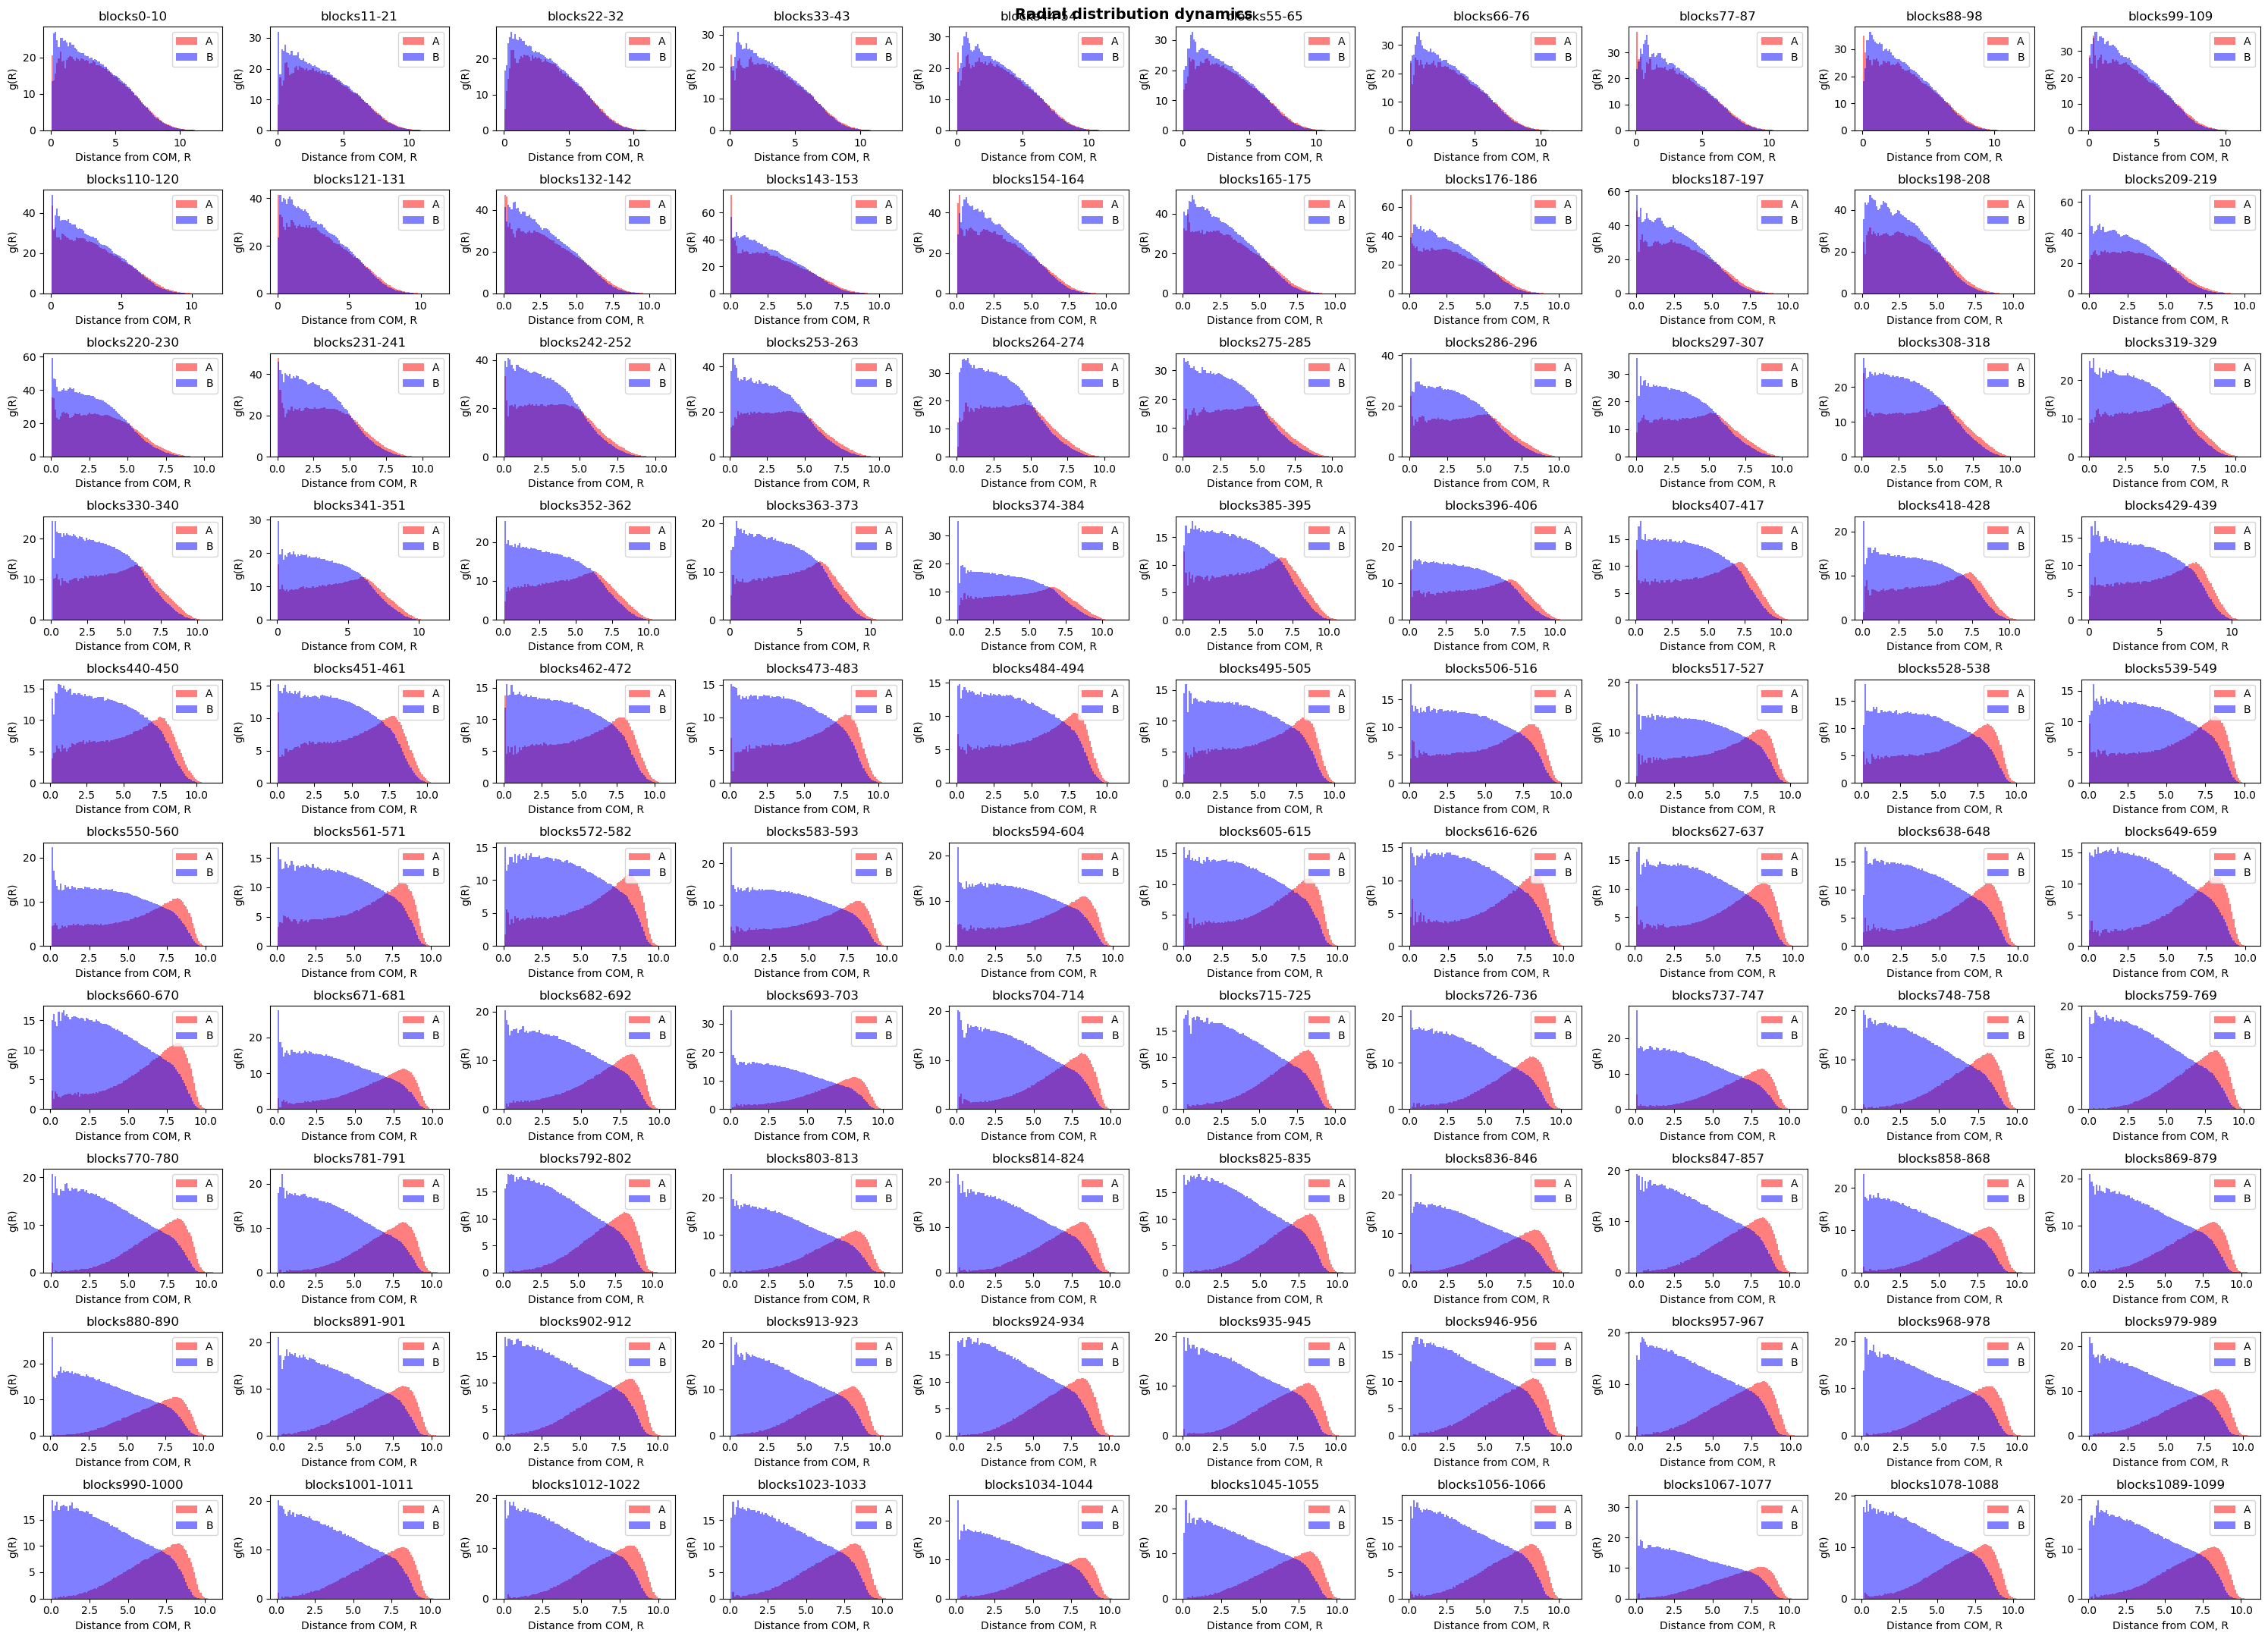

In [14]:
chromo = 'normal_logclustered'
ABids = np.loadtxt("data/ABidentities_chr21_Su2020_2perlocus.csv", dtype=str)
ids = (ABids == "A").astype(int)
num_A = 474
num_B = 828
param_set = [(1, 0.3)]
simnames = [f'stickyBB_{BBenergy}_act{act_ratio}' for (act_ratio, BBenergy) in param_set]
plot_radial_dynamics_panel(simnames, blocks=True)

In [ ]:
# save conformations to visualize above radial distributions as real polymers
chromo = 'normal'
# load chromosomal data
ABids = np.loadtxt("data/ABidentities_chr21_Su2020_2perlocus.csv", dtype=str) # make sure to change this!
ids = (ABids == "A").astype(int)
# save conformations
for simname in simnames:
    path = f'/home/gridsan/lchan/git-remotes/polychrom_analysis/artificial_chr/{chromo}/{simname}'
    conformations, runs = extract_conformations(path)
    np.save(f'/home/gridsan/lchan/git-remotes/polychrom_analysis/data/conformations/{chromo}/{simname}', conformations)

In [ ]:
#test snapshot visualization - by monomer id
chromo = 'normal'
confs = np.load(f'/home/gridsan/lchan/git-remotes/polychrom_analysis/data/conformations/{chromo}/stickyBB_0.075_act5.npy')
X = load_URI(confs[-1])['pos']
visualize(X, 20, ids=ids, color_by="monomer_id")